### Requirement

In [2]:
import keras,os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import cv2
import albumentations as A
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse
from sklearn.preprocessing import OneHotEncoder


### Function for Image Degradation and Noise Addition
This section defines a set of image augmentation functions designed to degrade image quality and introduce noise, enhancing model robustness in low-quality MRI scans. Techniques such as salt-and-pepper noise, Rician noise, and random noise simulate real-world distortions, while an augmentation pipeline using Albumentations applies transformations like image compression, downscaling, and color jittering. These modifications help train the algorithm to recognize brain tumor patterns in challenging imaging conditions.

In [3]:
def add_salt_pepper_noise(image):
    # Getting the dimensions of the image
    noisy_image = image.copy()
    row, col, _ = noisy_image.shape

    # Randomly pick some pixels in the image for coloring them white
    number_of_white_pixels = random.randint(300, 10000)
    white_coords = random.choices(range(row), k=number_of_white_pixels), random.choices(range(col), k=number_of_white_pixels)
    noisy_image[white_coords] = 255

    # Randomly pick some pixels in the image for coloring them black
    number_of_black_pixels = random.randint(300, 10000)
    black_coords = random.choices(range(row), k=number_of_black_pixels), random.choices(range(col), k=number_of_black_pixels)
    noisy_image[black_coords] = 0

    return noisy_image

def add_random_noise(image, intensity=25):
    noisy_image = image.copy()
    noise = np.random.randint(-intensity, intensity + 1, noisy_image.shape)
    noisy_image = np.clip(noisy_image + noise, 0, 255).astype(np.uint8)
    return noisy_image

def Rician_noise(image):
        noisy_image = image.copy()
        
        # Parameters of Rician noise
        mean = 5  # Mean of the noise
        stddev = 50  # Standard deviation of the noise
        intensity_scaling_factor = 0.6  # Scaling factor for the noise intensity

        # Generate Rician noise
        noise = np.random.normal(loc=mean, scale=stddev, size=noisy_image.shape)
        rician_noise = intensity_scaling_factor * noise

        # Add the noise to the image
        noisy_image = noisy_image + rician_noise

        # Normalize the pixel values to [0, 255]
        noisy_image = cv2.normalize(noisy_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return noisy_image

def add_Aaugment(image):
    noisy_image = image.copy()
    # Define the augmentation pipeline using Albumentations
    augmentation_pipeline = A.Compose([
                        A.OneOf([
                            A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True,p=1),
                            A.ImageCompression(quality_lower=30, quality_upper=50,p=1),
                            A.GaussNoise (var_limit=(50.0, 100.0),p=1) ,
                            A.Downscale(scale_min=0.25, scale_max=0.25,p=1),
                            A.GridDropout (ratio=0.2,p=1),
                            A.ColorJitter (brightness=0.5, contrast=0.2, saturation=0.2, hue=0.5,p=1)
                            ])
                      ],p=1)
    augmented = augmentation_pipeline(image=noisy_image)['image']
    return noisy_image



In [4]:
def add_noise(image,probability=0.5):
    if np.random.uniform() < probability:
            noisy_image = image.copy()
            augmentation_type = random.choice(['salt_pepper', 'random_noise', 'Rician','Albumentations' ])
            if augmentation_type == 'salt_pepper':
                  noisy_image = add_salt_pepper_noise(noisy_image)
            elif augmentation_type == 'random_noise':
                  noisy_image = add_random_noise(noisy_image)
            elif augmentation_type == 'Rician':
                  noisy_image = Rician_noise(noisy_image)
            elif augmentation_type ==  'Albumentations':
                  noisy_image = add_Aaugment(noisy_image)
            return noisy_image
    else:
          return image

#### Examples of Image Noise Addition Functions
Here, we load an example image and sequentially apply each noise function to observe the transformations

In [42]:
def visualize(image):
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(image)

In [43]:
image = cv2.imread('/content/drive/MyDrive/Data/glioma_tumor/G_1.jpg')

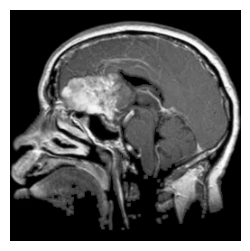

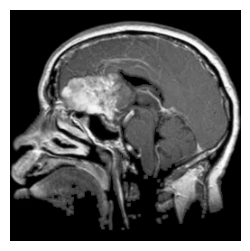

In [44]:
visualize(image)
transform = A.Compose([
     A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True)
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

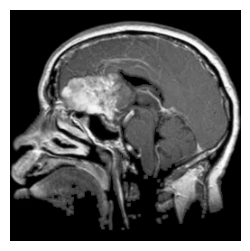

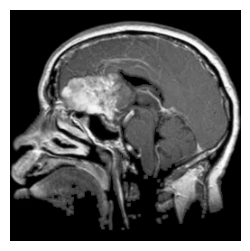

In [45]:
visualize(image)
transform = A.Compose([
     A.ImageCompression(quality_lower=30, quality_upper=50),
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

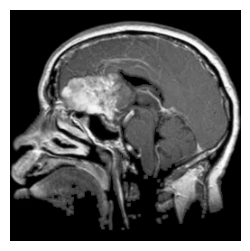

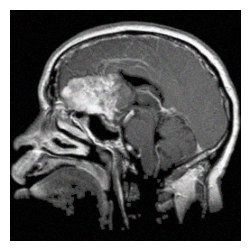

In [46]:
visualize(image)
transform = A.Compose([
     A.GaussNoise (var_limit=(50.0, 100.0))
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


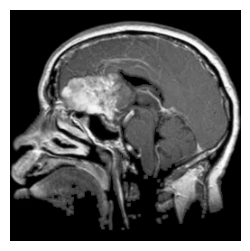

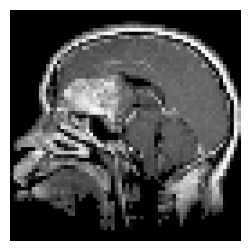

In [47]:
visualize(image)
transform = A.Compose([
     A.Downscale(scale_min=0.25, scale_max=0.25)
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

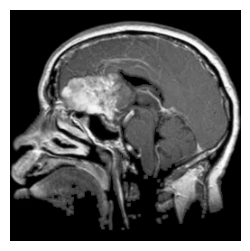

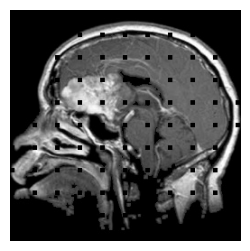

In [48]:
visualize(image)
transform = A.Compose([
     A.GridDropout (ratio=0.2)
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

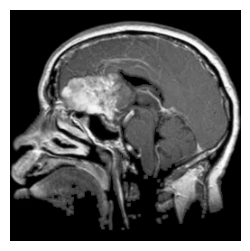

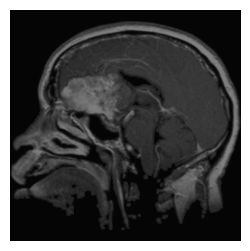

In [49]:
visualize(image)

transform = A.Compose([
   A.ColorJitter (brightness=0.5, contrast=0.2, saturation=0.2, hue=0.5)
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

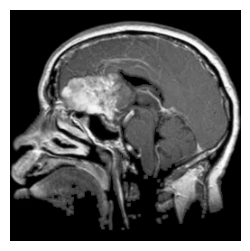

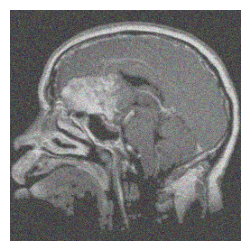

In [50]:
visualize(image)
augmented_image = Rician_noise(image)
visualize(augmented_image)

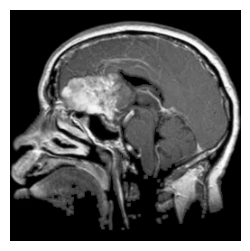

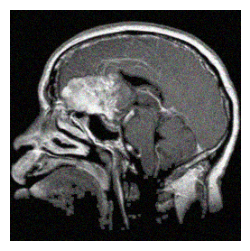

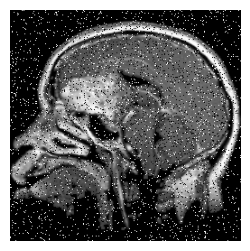

In [51]:
original_image = cv2.imread('/content/drive/MyDrive/Data/glioma_tumor/G_1.jpg')
visualize(original_image)
noisy_image= add_random_noise(original_image)
visualize(noisy_image)
noisy_image = add_salt_pepper_noise(original_image)
visualize(noisy_image)

### Image Loading and Augmentation
This section covers the process of loading images and applying augmentation techniques to enhance model training. Images are resized and converted into arrays, followed by the addition of noise and preprocessing steps to improve robustness. Augmentation ensures the model learns to classify brain tumors effectively, even in low-quality MRI scans.

In [9]:
imagePaths =  list(paths.list_images('/content/drive/MyDrive/Data'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    noisy_image = add_noise(image, probability=0.5)
    noisy_image = img_to_array(noisy_image)

    if not np.array_equal(noisy_image, image):
        preprocessed_image = preprocess_input(noisy_image)
        data.append(preprocessed_image)
        labels.append(label)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/functional.py:487: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


In [10]:
len(data)

4226

In [11]:
len(labels)

4226

In [12]:
np.save('/content/drive/MyDrive/filogerfinal/datav3.npy', data)

In [13]:
np.save('/content/drive/MyDrive/filogerfinal/labelsv3.npy', labels)

In [14]:
arrdata = np.array(data, dtype="float32")
arrlabels = np.array(labels)

In [15]:
lb = LabelBinarizer()
arrlabels = lb.fit_transform(arrlabels)

In [16]:
np.unique(labels)

array(['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor'],
      dtype='<U16')

In [ ]:
data = np.load('/content/drive/MyDrive/filogerfinal/data.npy')
labels = np.load('/content/drive/MyDrive/filogerfinal/labels.npy')

### Split data into train/test set and define Data Generator

In [17]:
(trainX, testX, trainY, testY) = train_test_split(arrdata, arrlabels, test_size=0.20, stratify=arrlabels, random_state=42)

In [18]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [28]:
import gc
del(data)
del(labels)
gc.collect()

759

### Model Architecture Using InceptionV3
Defines a deep learning model using InceptionV3 as a feature extractor, followed by pooling, dense layers, and dropout for classification. The base model's layers are frozen to retain pretrained weights.

In [19]:
baseModel = InceptionV3(weights='imagenet', include_top=False , input_tensor=Input(shape=(224, 224, 3)))

87910968/87910968 [==============================] - 1s 0us/step


In [20]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5,5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

In [21]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [22]:
for layer in baseModel.layers:
    layer.trainable = False

### Training Configuration and Optimization Settings
Defines learning rate scheduling, early stopping, and model checkpointing to optimize training stability and performance. Uses exponential decay and adaptive optimization for efficient convergence.

In [23]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [24]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.00001)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=10000,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [25]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [26]:
mch = ModelCheckpoint('/content/drive/MyDrive/classifier.h5', monitor='val_loss', mode='min', save_best_only=True)

### Handling Class Imbalance with Weighted Adjustments
When certain classes appear less frequently, models tend to favor the majority class, leading to biased predictions. Assigning higher weights to underrepresented classes ensures the model learns from them more effectively, improving overall performance and fairness.

In [27]:
decoded_labels = lb.inverse_transform(arrlabels)
weights = compute_class_weight(class_weight='balanced', classes=np.unique(decoded_labels), y=decoded_labels)
class_weights = dict(zip(np.unique(decoded_labels), weights))
class_weights = {i: class_weights[label] for i, label in enumerate(class_weights)}
class_weights

{0: 0.8631535947712419,
 1: 0.8506441223832528,
 2: 1.7491721854304636,
 3: 0.9139273356401384}

### Training the Model

In [29]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[es, reduce_lr, mch],
    class_weight=class_weights
)

Epoch 1/20
105/105 [==============================] - ETA: 0s - loss: 1.3260 - accuracy: 0.3990

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 352s 3s/step - loss: 1.3260 - accuracy: 0.3990 - val_loss: 1.0571 - val_accuracy: 0.5697 - lr: 9.9890e-05
Epoch 2/20
105/105 [==============================] - 327s 3s/step - loss: 1.0822 - accuracy: 0.5263 - val_loss: 0.9482 - val_accuracy: 0.6170 - lr: 9.9780e-05
Epoch 3/20
105/105 [==============================] - 351s 3s/step - loss: 0.9745 - accuracy: 0.5738 - val_loss: 0.8843 - val_accuracy: 0.6300 - lr: 9.9670e-05
Epoch 4/20
105/105 [==============================] - 350s 3s/step - loss: 0.9296 - accuracy: 0.5935 - val_loss: 0.7894 - val_accuracy: 0.6962 - lr: 9.9560e-05
Epoch 5/20
105/105 [==============================] - 347s 3s/step - loss: 0.8813 - accuracy: 0.6249 - val_loss: 0.7613 - val_accuracy: 0.7057 - lr: 9.9449e-05
Epoch 6/20
105/105 [==============================] - 344s 3s/step - loss: 0.8439 - accuracy: 0.6344 - val_loss: 0.7663 - val_accuracy: 0.6844 - lr: 9.9339e-05
Epoch 7/20
105/105 [==============================]

#### Final model training completed with stable loss and improved accuracy. Validation accuracy (~77%) surpasses training, indicating strong generalization.

In [30]:
model.save('/content/drive/MyDrive/filogerfinal/trained_model.h5', save_format="h5")

### Analysis of Training Results

In [ ]:
model = load_model('/content/drive/MyDrive/trained_model.h5')

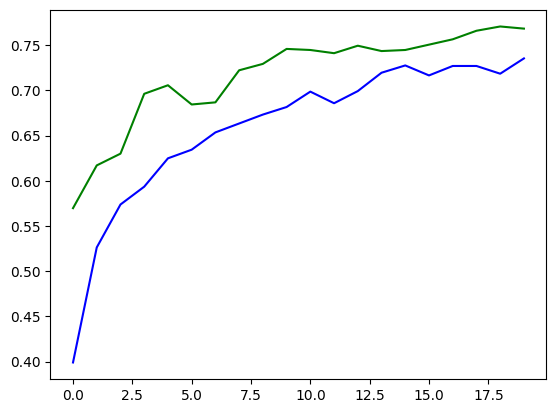

In [32]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.plot(H.history['accuracy'], color='blue')
plt.plot(H.history['val_accuracy'], color='green')

##### This graph illustrates the learning progression of model over 20 epochs, comparing train accuracy (blue line) and validation accuracy (green line). 
#### Epochs 0-5: The train accuracy starts around 0.4 and steadily increases, while the validation accuracy begins higher at around 0.55 and rises more rapidly.This suggests the model is effectively learning patterns from the training data without immediately overfitting. 
#### Epochs 5-10: The validation accuracy surpasses the train accuracy and continues to improve, reaching around 0.75. 
#### Epochs 10-20: Both accuracy values stabilize within the 0.65–0.75 range.
The model shows steady improvement, with training accuracy rising consistently. Validation accuracy initially surpasses training, indicating strong generalization. Later epochs exhibit stabilization, though minor fluctuations suggest fine-tuning is needed. Further optimization may enhance performance and reduce overfitting risks. 

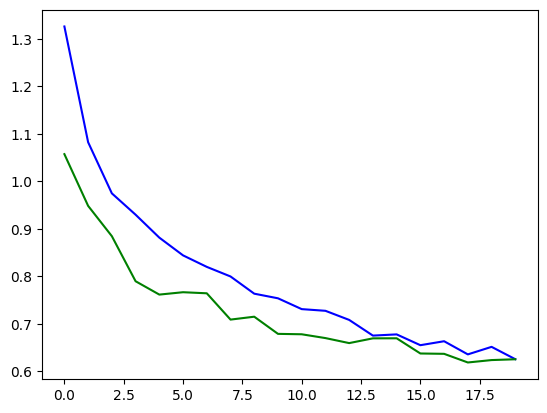

In [33]:
plt.plot(H.history['loss'], color='blue')
plt.plot(H.history['val_loss'], color='green')

#### This graph illustrates the training loss (blue line) and validation loss (green line) trends over 20 epochs.
The model's training loss decreases steadily, showing effective learning. Validation loss initially follows but stabilizes, indicating good generalization. A slight gap suggests potential overfitting, requiring careful tuning. Further adjustments may refine performance and enhance stability.